# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.1MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

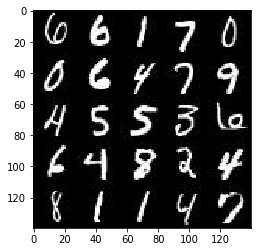

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

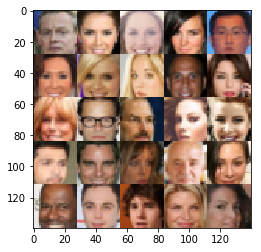

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [90]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [91]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    imageShape = (image_width, image_height, image_channels)
    discInput = tf.placeholder(dtype=tf.float32, shape=(None, *imageShape))
    genImput = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    learningRate = tf.placeholder(dtype=tf.float32)

    return discInput, genImput, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [92]:
def discriminator(images, reuse=False, alpha=0.1, is_training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        conv1 = tf.maximum(alpha * conv1, conv1)  # (32, 32, 16)
        # -------------------------------------------
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_training)
        conv2 = tf.maximum(alpha * conv2, conv2)  # (16, 16, 64)
        conv2 = tf.layers.dropout(conv2, 0.1)
        # -------------------------------------------
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding="same")
        conv3 = tf.layers.batch_normalization(conv3, training=is_training)
        conv3 = tf.maximum(alpha * conv3, conv3)  # (8, 8, 256)
        conv3 = tf.layers.dropout(conv3, 0.1)
        # -------------------------------------------
        conv4 = tf.layers.conv2d(conv3, 512, 3, strides=2, padding="same")
        flattened = tf.reshape(conv4, (-1, 4 * 4 * 512))   # (4, 4, 512)
        dense = tf.layers.dense(flattened, 512)
        dense = tf.maximum(alpha * dense, dense)
        # -------------------------------------------
        dense = tf.layers.dense(dense, 1024)
        dense = tf.maximum(alpha * dense, dense)
        logits = tf.layers.dense(dense, 1)
        prediction = tf.nn.sigmoid(logits)
    
    return logits, prediction

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train):
        
        x = tf.layers.dense(z, 7 * 7 * 512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)  # (7, 7, 512)
        # -------------------------------------------
        conv1 = tf.layers.conv2d_transpose(x, 256, 3, strides=2, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1) 
        conv1 = tf.layers.dropout(conv1, 0.2)
        # -------------------------------------------
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=1, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)  
        conv2 = tf.layers.dropout(conv2, 0.2)
        # -------------------------------------------
        conv2 = tf.layers.conv2d_transpose(conv2, 32, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2) 
        conv2 = tf.layers.dropout(conv2, 0.1)
        # -------------------------------------------
        conv3 = tf.layers.conv2d_transpose(conv2, out_channel_dim, 7, strides=1, padding="same")
        fakeOut = tf.nn.tanh(conv3)  # (28, 28, 3)


    return fakeOut


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [84]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    fake_imgs = generator(input_z, out_channel_dim)
    disc_real_logits, disc_real_out = discriminator(input_real)
    disc_fake_logits, disc_fake_out = discriminator(fake_imgs, reuse=True)

    
    disc_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits= disc_real_logits,
            labels= tf.ones_like(disc_real_out) * (1 - smooth)
        )
    )
    
    disc_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits= disc_fake_logits,
            labels= tf.zeros_like(disc_fake_out)
        )
    )
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits= disc_fake_logits,
            labels= tf.ones_like(disc_fake_out)
        )
    )
    
    disc_loss = disc_real_loss + disc_fake_loss
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [86]:
def model_opt(d_loss, g_loss, learning_rate, beta):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    params = tf.trainable_variables()
    gen_params = [param for param in params if param.name.startswith("generator")]
    disc_params = [param for param in params if param.name.startswith("discriminator")]
    
    optimizer = tf.train.AdamOptimizer(learning_rate, beta)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_grads = optimizer.minimize(d_loss, var_list=disc_params)
        gen_grads = optimizer.minimize(g_loss, var_list=gen_params)

    return disc_grads, gen_grads


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [94]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver(var_list=tf.trainable_variables())
    disc_input, gen_input, learningRate = model_inputs(*data_shape[1:], z_dim)
    disc_loss_, gen_loss_ = model_loss(disc_input, gen_input, out_channel_dim=data_shape[3])
    disc_grads, gen_grads = model_opt(disc_loss_, gen_loss_, beta=beta1, learning_rate=learning_rate)

    
    steps = 0
    history, samples = [], []
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2  # enhanced generated couldn't find why only 2 works
                noise_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                feed_dict={
                        disc_input: batch_images,
                        gen_input: noise_batch,
                        learningRate: learning_rate
                    }
                
                _ = sess.run(disc_grads, feed_dict= feed_dict)
                _ = sess.run(gen_grads, feed_dict= feed_dict)

                    
                if steps % 10 == 0:
                    disc_loss = disc_loss_.eval(feed_dict)
                    gen_loss = gen_loss_.eval({gen_input: noise_batch})
                    history.append((disc_loss, gen_loss))
                    
                    print(
                        f"Epoch {epoch_i+1}/{epoch_count}",
                        f"disc_loss: {disc_loss: .3f}", 
                        f"gen_loss: {gen_loss: .3f}"
                    )
                
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, gen_input, data_shape[3], data_image_mode)
                    
        model_path = saver.save(sess, "./checkpoint/gan.ckpt")
        
    return history, model_path

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 disc_loss:  0.997 gen_loss:  0.804
Epoch 1/2 disc_loss:  1.406 gen_loss:  0.507
Epoch 1/2 disc_loss:  1.253 gen_loss:  2.316
Epoch 1/2 disc_loss:  0.910 gen_loss:  2.091
Epoch 1/2 disc_loss:  2.085 gen_loss:  0.217
Epoch 1/2 disc_loss:  3.795 gen_loss:  7.045
Epoch 1/2 disc_loss:  1.137 gen_loss:  0.762
Epoch 1/2 disc_loss:  1.006 gen_loss:  0.923
Epoch 1/2 disc_loss:  0.998 gen_loss:  1.064
Epoch 1/2 disc_loss:  1.137 gen_loss:  0.818


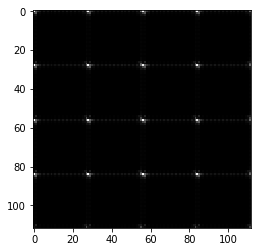

Epoch 1/2 disc_loss:  1.267 gen_loss:  0.598
Epoch 1/2 disc_loss:  1.258 gen_loss:  0.833
Epoch 1/2 disc_loss:  1.078 gen_loss:  1.260
Epoch 1/2 disc_loss:  1.196 gen_loss:  1.159
Epoch 1/2 disc_loss:  1.176 gen_loss:  0.803
Epoch 1/2 disc_loss:  1.147 gen_loss:  0.802
Epoch 1/2 disc_loss:  1.139 gen_loss:  1.218
Epoch 1/2 disc_loss:  1.062 gen_loss:  0.979
Epoch 1/2 disc_loss:  1.281 gen_loss:  0.595
Epoch 1/2 disc_loss:  1.321 gen_loss:  1.255


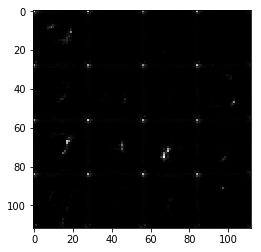

Epoch 1/2 disc_loss:  1.155 gen_loss:  1.281
Epoch 1/2 disc_loss:  1.275 gen_loss:  1.105
Epoch 1/2 disc_loss:  1.078 gen_loss:  0.974
Epoch 1/2 disc_loss:  1.123 gen_loss:  1.330
Epoch 1/2 disc_loss:  1.255 gen_loss:  1.017
Epoch 1/2 disc_loss:  1.734 gen_loss:  0.308
Epoch 1/2 disc_loss:  1.289 gen_loss:  0.571
Epoch 1/2 disc_loss:  1.112 gen_loss:  0.919
Epoch 1/2 disc_loss:  1.611 gen_loss:  0.346
Epoch 1/2 disc_loss:  1.009 gen_loss:  1.054


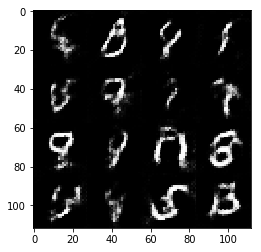

Epoch 1/2 disc_loss:  1.099 gen_loss:  1.067
Epoch 1/2 disc_loss:  1.285 gen_loss:  0.583
Epoch 1/2 disc_loss:  1.122 gen_loss:  1.095
Epoch 1/2 disc_loss:  1.776 gen_loss:  0.289
Epoch 1/2 disc_loss:  1.669 gen_loss:  0.321
Epoch 1/2 disc_loss:  1.159 gen_loss:  0.963
Epoch 1/2 disc_loss:  1.216 gen_loss:  0.776
Epoch 1/2 disc_loss:  1.257 gen_loss:  0.664
Epoch 1/2 disc_loss:  0.892 gen_loss:  1.363
Epoch 1/2 disc_loss:  1.102 gen_loss:  1.150


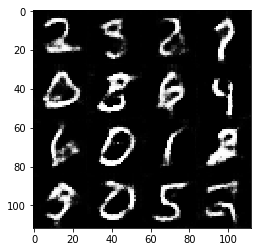

Epoch 1/2 disc_loss:  1.280 gen_loss:  1.573
Epoch 1/2 disc_loss:  1.305 gen_loss:  0.900
Epoch 1/2 disc_loss:  1.310 gen_loss:  0.523
Epoch 1/2 disc_loss:  1.093 gen_loss:  1.568
Epoch 1/2 disc_loss:  1.144 gen_loss:  1.508
Epoch 1/2 disc_loss:  1.059 gen_loss:  0.877
Epoch 2/2 disc_loss:  1.111 gen_loss:  0.871
Epoch 2/2 disc_loss:  1.002 gen_loss:  1.214
Epoch 2/2 disc_loss:  1.064 gen_loss:  0.993
Epoch 2/2 disc_loss:  1.361 gen_loss:  0.497


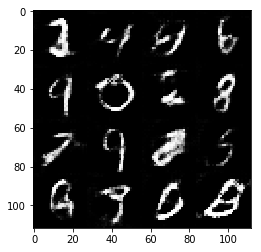

Epoch 2/2 disc_loss:  1.036 gen_loss:  1.010
Epoch 2/2 disc_loss:  1.102 gen_loss:  0.903
Epoch 2/2 disc_loss:  1.104 gen_loss:  0.951
Epoch 2/2 disc_loss:  1.078 gen_loss:  0.918
Epoch 2/2 disc_loss:  1.000 gen_loss:  1.225
Epoch 2/2 disc_loss:  1.046 gen_loss:  1.216
Epoch 2/2 disc_loss:  1.273 gen_loss:  0.901
Epoch 2/2 disc_loss:  1.703 gen_loss:  0.319
Epoch 2/2 disc_loss:  1.023 gen_loss:  1.011
Epoch 2/2 disc_loss:  1.115 gen_loss:  1.122


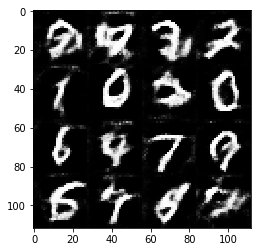

Epoch 2/2 disc_loss:  1.608 gen_loss:  0.350
Epoch 2/2 disc_loss:  1.160 gen_loss:  0.808
Epoch 2/2 disc_loss:  1.143 gen_loss:  1.027
Epoch 2/2 disc_loss:  1.022 gen_loss:  1.212
Epoch 2/2 disc_loss:  1.005 gen_loss:  1.092
Epoch 2/2 disc_loss:  1.162 gen_loss:  0.829
Epoch 2/2 disc_loss:  1.559 gen_loss:  0.371
Epoch 2/2 disc_loss:  1.051 gen_loss:  1.209
Epoch 2/2 disc_loss:  1.026 gen_loss:  1.053
Epoch 2/2 disc_loss:  1.217 gen_loss:  1.517


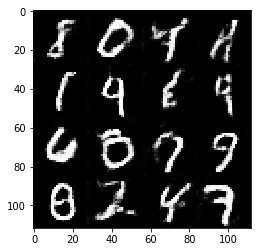

Epoch 2/2 disc_loss:  1.408 gen_loss:  0.477
Epoch 2/2 disc_loss:  1.074 gen_loss:  0.925
Epoch 2/2 disc_loss:  1.242 gen_loss:  1.789
Epoch 2/2 disc_loss:  1.040 gen_loss:  0.922
Epoch 2/2 disc_loss:  1.307 gen_loss:  0.563
Epoch 2/2 disc_loss:  1.148 gen_loss:  0.777
Epoch 2/2 disc_loss:  1.030 gen_loss:  1.008
Epoch 2/2 disc_loss:  2.891 gen_loss:  0.093
Epoch 2/2 disc_loss:  1.269 gen_loss:  0.636
Epoch 2/2 disc_loss:  1.246 gen_loss:  0.932


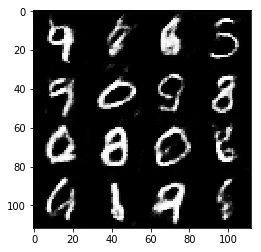

Epoch 2/2 disc_loss:  1.252 gen_loss:  1.639
Epoch 2/2 disc_loss:  1.281 gen_loss:  0.566
Epoch 2/2 disc_loss:  1.349 gen_loss:  0.533
Epoch 2/2 disc_loss:  1.186 gen_loss:  0.771
Epoch 2/2 disc_loss:  1.067 gen_loss:  0.948
Epoch 2/2 disc_loss:  1.135 gen_loss:  1.020
Epoch 2/2 disc_loss:  1.195 gen_loss:  0.927
Epoch 2/2 disc_loss:  1.376 gen_loss:  0.493
Epoch 2/2 disc_loss:  1.176 gen_loss:  0.716
Epoch 2/2 disc_loss:  1.020 gen_loss:  1.037


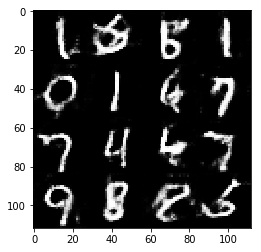

Epoch 2/2 disc_loss:  0.974 gen_loss:  1.162
Epoch 2/2 disc_loss:  1.071 gen_loss:  1.342
Epoch 2/2 disc_loss:  1.355 gen_loss:  2.241


In [96]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    hist, mod_path = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 disc_loss:  0.870 gen_loss:  1.044
Epoch 1/1 disc_loss:  5.343 gen_loss:  0.009
Epoch 1/1 disc_loss:  1.833 gen_loss:  0.261
Epoch 1/1 disc_loss:  1.084 gen_loss:  0.657
Epoch 1/1 disc_loss:  2.442 gen_loss:  6.748
Epoch 1/1 disc_loss:  1.488 gen_loss:  0.414
Epoch 1/1 disc_loss:  1.099 gen_loss:  0.745
Epoch 1/1 disc_loss:  0.669 gen_loss:  1.323
Epoch 1/1 disc_loss:  0.981 gen_loss:  3.258
Epoch 1/1 disc_loss:  1.079 gen_loss:  1.056


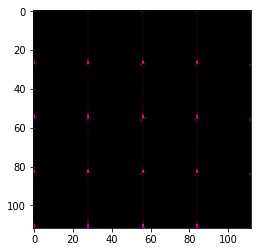

Epoch 1/1 disc_loss:  0.851 gen_loss:  1.165
Epoch 1/1 disc_loss:  1.709 gen_loss:  0.378
Epoch 1/1 disc_loss:  1.112 gen_loss:  0.687
Epoch 1/1 disc_loss:  1.245 gen_loss:  0.602
Epoch 1/1 disc_loss:  0.845 gen_loss:  1.062
Epoch 1/1 disc_loss:  1.051 gen_loss:  0.764
Epoch 1/1 disc_loss:  1.302 gen_loss:  0.586
Epoch 1/1 disc_loss:  0.790 gen_loss:  1.425
Epoch 1/1 disc_loss:  1.266 gen_loss:  0.675
Epoch 1/1 disc_loss:  0.753 gen_loss:  1.623


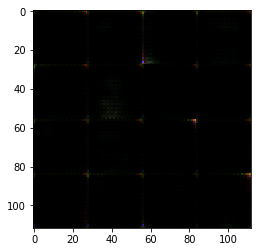

Epoch 1/1 disc_loss:  1.996 gen_loss:  0.264
Epoch 1/1 disc_loss:  0.741 gen_loss:  1.295
Epoch 1/1 disc_loss:  1.242 gen_loss:  0.570
Epoch 1/1 disc_loss:  0.640 gen_loss:  1.685
Epoch 1/1 disc_loss:  1.069 gen_loss:  0.768
Epoch 1/1 disc_loss:  0.689 gen_loss:  2.504
Epoch 1/1 disc_loss:  0.624 gen_loss:  1.653
Epoch 1/1 disc_loss:  0.752 gen_loss:  1.390
Epoch 1/1 disc_loss:  1.126 gen_loss:  0.681
Epoch 1/1 disc_loss:  0.801 gen_loss:  1.777


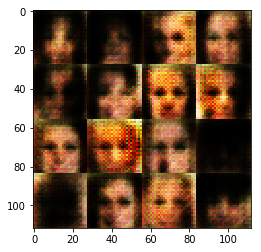

Epoch 1/1 disc_loss:  0.909 gen_loss:  1.406
Epoch 1/1 disc_loss:  0.981 gen_loss:  1.100
Epoch 1/1 disc_loss:  1.331 gen_loss:  0.549
Epoch 1/1 disc_loss:  1.189 gen_loss:  2.260
Epoch 1/1 disc_loss:  1.006 gen_loss:  1.113
Epoch 1/1 disc_loss:  2.522 gen_loss:  0.132
Epoch 1/1 disc_loss:  1.178 gen_loss:  2.075
Epoch 1/1 disc_loss:  0.932 gen_loss:  0.939
Epoch 1/1 disc_loss:  1.407 gen_loss:  0.512
Epoch 1/1 disc_loss:  1.488 gen_loss:  0.390


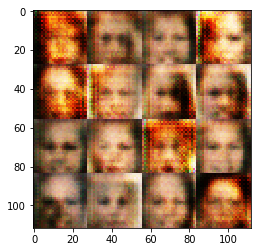

Epoch 1/1 disc_loss:  1.010 gen_loss:  1.040
Epoch 1/1 disc_loss:  1.677 gen_loss:  0.343
Epoch 1/1 disc_loss:  1.110 gen_loss:  0.696
Epoch 1/1 disc_loss:  0.821 gen_loss:  1.662
Epoch 1/1 disc_loss:  1.276 gen_loss:  0.632
Epoch 1/1 disc_loss:  0.920 gen_loss:  1.008
Epoch 1/1 disc_loss:  1.077 gen_loss:  1.039
Epoch 1/1 disc_loss:  1.029 gen_loss:  2.890
Epoch 1/1 disc_loss:  1.536 gen_loss:  0.380
Epoch 1/1 disc_loss:  0.651 gen_loss:  1.785


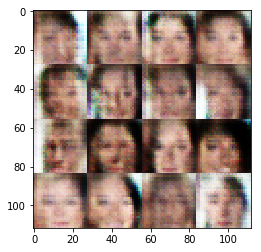

Epoch 1/1 disc_loss:  0.851 gen_loss:  1.272
Epoch 1/1 disc_loss:  0.730 gen_loss:  1.423
Epoch 1/1 disc_loss:  1.046 gen_loss:  0.840
Epoch 1/1 disc_loss:  1.117 gen_loss:  1.046
Epoch 1/1 disc_loss:  0.920 gen_loss:  0.948
Epoch 1/1 disc_loss:  1.411 gen_loss:  0.472
Epoch 1/1 disc_loss:  0.849 gen_loss:  1.657
Epoch 1/1 disc_loss:  0.842 gen_loss:  1.061
Epoch 1/1 disc_loss:  1.050 gen_loss:  1.208
Epoch 1/1 disc_loss:  1.059 gen_loss:  0.828


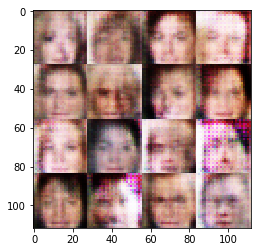

Epoch 1/1 disc_loss:  1.026 gen_loss:  0.811
Epoch 1/1 disc_loss:  0.825 gen_loss:  1.227
Epoch 1/1 disc_loss:  1.292 gen_loss:  0.519
Epoch 1/1 disc_loss:  0.937 gen_loss:  0.909
Epoch 1/1 disc_loss:  0.852 gen_loss:  1.168
Epoch 1/1 disc_loss:  1.981 gen_loss:  0.232
Epoch 1/1 disc_loss:  1.116 gen_loss:  0.752
Epoch 1/1 disc_loss:  0.964 gen_loss:  1.369
Epoch 1/1 disc_loss:  0.922 gen_loss:  0.947
Epoch 1/1 disc_loss:  1.092 gen_loss:  1.220


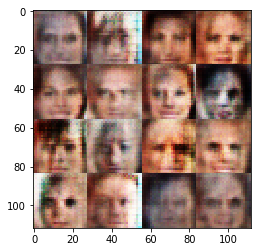

Epoch 1/1 disc_loss:  1.000 gen_loss:  1.566
Epoch 1/1 disc_loss:  0.792 gen_loss:  1.428
Epoch 1/1 disc_loss:  0.874 gen_loss:  1.124
Epoch 1/1 disc_loss:  0.894 gen_loss:  1.045
Epoch 1/1 disc_loss:  1.432 gen_loss:  0.483
Epoch 1/1 disc_loss:  0.778 gen_loss:  1.268
Epoch 1/1 disc_loss:  0.997 gen_loss:  1.034
Epoch 1/1 disc_loss:  0.812 gen_loss:  1.438
Epoch 1/1 disc_loss:  1.455 gen_loss:  0.457
Epoch 1/1 disc_loss:  1.122 gen_loss:  0.771


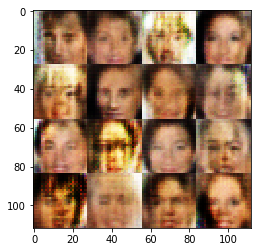

Epoch 1/1 disc_loss:  0.851 gen_loss:  1.201
Epoch 1/1 disc_loss:  0.880 gen_loss:  1.224
Epoch 1/1 disc_loss:  0.725 gen_loss:  1.654
Epoch 1/1 disc_loss:  0.764 gen_loss:  1.491
Epoch 1/1 disc_loss:  1.008 gen_loss:  1.075
Epoch 1/1 disc_loss:  1.292 gen_loss:  0.668
Epoch 1/1 disc_loss:  1.420 gen_loss:  0.574
Epoch 1/1 disc_loss:  0.869 gen_loss:  1.469
Epoch 1/1 disc_loss:  0.900 gen_loss:  0.995
Epoch 1/1 disc_loss:  1.514 gen_loss:  0.405


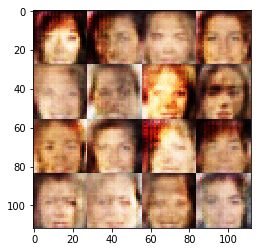

Epoch 1/1 disc_loss:  0.934 gen_loss:  0.982
Epoch 1/1 disc_loss:  1.143 gen_loss:  0.749
Epoch 1/1 disc_loss:  1.168 gen_loss:  0.701
Epoch 1/1 disc_loss:  1.846 gen_loss:  0.273
Epoch 1/1 disc_loss:  1.074 gen_loss:  0.754
Epoch 1/1 disc_loss:  1.458 gen_loss:  2.494
Epoch 1/1 disc_loss:  0.989 gen_loss:  0.904
Epoch 1/1 disc_loss:  1.067 gen_loss:  0.826
Epoch 1/1 disc_loss:  1.161 gen_loss:  0.720
Epoch 1/1 disc_loss:  1.005 gen_loss:  0.942


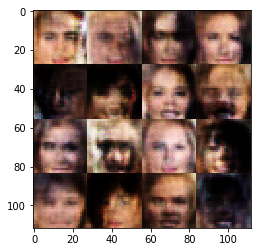

Epoch 1/1 disc_loss:  0.969 gen_loss:  1.176
Epoch 1/1 disc_loss:  0.816 gen_loss:  1.313
Epoch 1/1 disc_loss:  1.521 gen_loss:  0.458
Epoch 1/1 disc_loss:  0.989 gen_loss:  0.879
Epoch 1/1 disc_loss:  0.838 gen_loss:  1.227
Epoch 1/1 disc_loss:  0.877 gen_loss:  1.309
Epoch 1/1 disc_loss:  0.897 gen_loss:  1.078
Epoch 1/1 disc_loss:  1.220 gen_loss:  0.718
Epoch 1/1 disc_loss:  0.885 gen_loss:  1.216
Epoch 1/1 disc_loss:  0.850 gen_loss:  2.080


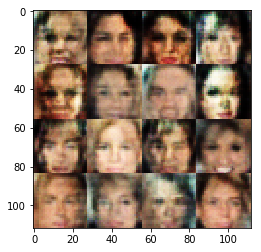

Epoch 1/1 disc_loss:  0.883 gen_loss:  1.150
Epoch 1/1 disc_loss:  0.835 gen_loss:  1.122
Epoch 1/1 disc_loss:  0.960 gen_loss:  1.131
Epoch 1/1 disc_loss:  0.759 gen_loss:  1.637
Epoch 1/1 disc_loss:  1.363 gen_loss:  0.512
Epoch 1/1 disc_loss:  0.656 gen_loss:  2.574
Epoch 1/1 disc_loss:  0.932 gen_loss:  1.146
Epoch 1/1 disc_loss:  0.773 gen_loss:  1.594
Epoch 1/1 disc_loss:  1.092 gen_loss:  1.032
Epoch 1/1 disc_loss:  0.744 gen_loss:  1.671


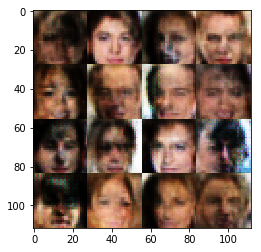

Epoch 1/1 disc_loss:  1.048 gen_loss:  1.048
Epoch 1/1 disc_loss:  1.245 gen_loss:  0.784
Epoch 1/1 disc_loss:  1.010 gen_loss:  1.059
Epoch 1/1 disc_loss:  0.942 gen_loss:  1.155
Epoch 1/1 disc_loss:  0.878 gen_loss:  0.975
Epoch 1/1 disc_loss:  1.048 gen_loss:  0.977
Epoch 1/1 disc_loss:  1.137 gen_loss:  0.696
Epoch 1/1 disc_loss:  1.405 gen_loss:  0.504
Epoch 1/1 disc_loss:  1.671 gen_loss:  0.412
Epoch 1/1 disc_loss:  1.419 gen_loss:  0.572


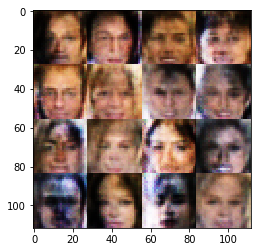

Epoch 1/1 disc_loss:  0.987 gen_loss:  1.250
Epoch 1/1 disc_loss:  1.328 gen_loss:  0.631
Epoch 1/1 disc_loss:  1.138 gen_loss:  0.816
Epoch 1/1 disc_loss:  0.920 gen_loss:  1.827
Epoch 1/1 disc_loss:  1.068 gen_loss:  0.889
Epoch 1/1 disc_loss:  0.803 gen_loss:  1.540
Epoch 1/1 disc_loss:  0.858 gen_loss:  1.412
Epoch 1/1 disc_loss:  0.655 gen_loss:  1.736
Epoch 1/1 disc_loss:  1.084 gen_loss:  0.995
Epoch 1/1 disc_loss:  1.110 gen_loss:  0.726


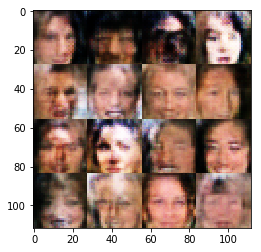

Epoch 1/1 disc_loss:  1.578 gen_loss:  3.849
Epoch 1/1 disc_loss:  0.998 gen_loss:  0.953
Epoch 1/1 disc_loss:  1.336 gen_loss:  0.660
Epoch 1/1 disc_loss:  1.736 gen_loss:  0.315
Epoch 1/1 disc_loss:  1.691 gen_loss:  0.368
Epoch 1/1 disc_loss:  0.933 gen_loss:  1.420
Epoch 1/1 disc_loss:  1.259 gen_loss:  0.672
Epoch 1/1 disc_loss:  0.880 gen_loss:  1.339
Epoch 1/1 disc_loss:  1.152 gen_loss:  0.792
Epoch 1/1 disc_loss:  1.421 gen_loss:  0.477


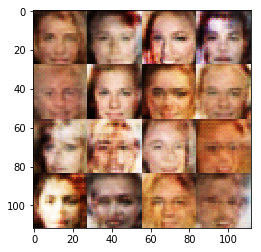

Epoch 1/1 disc_loss:  1.045 gen_loss:  0.955
Epoch 1/1 disc_loss:  1.278 gen_loss:  0.613
Epoch 1/1 disc_loss:  1.319 gen_loss:  0.533
Epoch 1/1 disc_loss:  1.136 gen_loss:  0.958
Epoch 1/1 disc_loss:  1.331 gen_loss:  0.617
Epoch 1/1 disc_loss:  1.059 gen_loss:  1.105
Epoch 1/1 disc_loss:  1.046 gen_loss:  0.927
Epoch 1/1 disc_loss:  0.971 gen_loss:  1.029
Epoch 1/1 disc_loss:  1.299 gen_loss:  0.649
Epoch 1/1 disc_loss:  0.859 gen_loss:  1.074


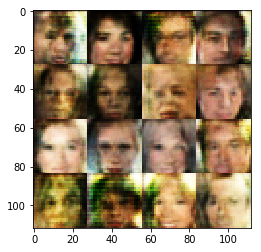

Epoch 1/1 disc_loss:  1.332 gen_loss:  0.696
Epoch 1/1 disc_loss:  1.424 gen_loss:  0.711
Epoch 1/1 disc_loss:  1.389 gen_loss:  0.520
Epoch 1/1 disc_loss:  1.325 gen_loss:  0.665
Epoch 1/1 disc_loss:  1.096 gen_loss:  0.895
Epoch 1/1 disc_loss:  1.120 gen_loss:  1.214
Epoch 1/1 disc_loss:  1.023 gen_loss:  0.930
Epoch 1/1 disc_loss:  1.218 gen_loss:  0.731
Epoch 1/1 disc_loss:  1.135 gen_loss:  0.886
Epoch 1/1 disc_loss:  1.073 gen_loss:  1.249


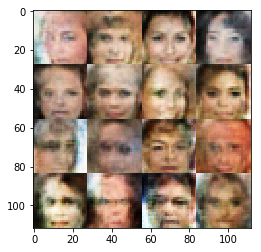

Epoch 1/1 disc_loss:  1.248 gen_loss:  0.711
Epoch 1/1 disc_loss:  0.909 gen_loss:  1.431
Epoch 1/1 disc_loss:  1.086 gen_loss:  0.885
Epoch 1/1 disc_loss:  1.297 gen_loss:  0.754
Epoch 1/1 disc_loss:  1.112 gen_loss:  0.876
Epoch 1/1 disc_loss:  0.917 gen_loss:  1.370
Epoch 1/1 disc_loss:  1.018 gen_loss:  0.847
Epoch 1/1 disc_loss:  1.540 gen_loss:  0.423
Epoch 1/1 disc_loss:  0.923 gen_loss:  1.236
Epoch 1/1 disc_loss:  0.949 gen_loss:  1.143


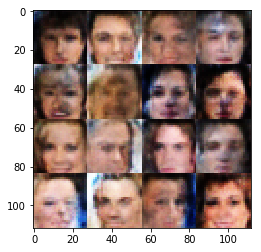

Epoch 1/1 disc_loss:  0.934 gen_loss:  1.166
Epoch 1/1 disc_loss:  1.068 gen_loss:  0.746
Epoch 1/1 disc_loss:  1.810 gen_loss:  0.322
Epoch 1/1 disc_loss:  1.262 gen_loss:  0.667
Epoch 1/1 disc_loss:  0.819 gen_loss:  1.998
Epoch 1/1 disc_loss:  1.320 gen_loss:  0.650
Epoch 1/1 disc_loss:  1.625 gen_loss:  0.338
Epoch 1/1 disc_loss:  1.248 gen_loss:  0.627
Epoch 1/1 disc_loss:  1.638 gen_loss:  0.447
Epoch 1/1 disc_loss:  2.243 gen_loss:  0.329


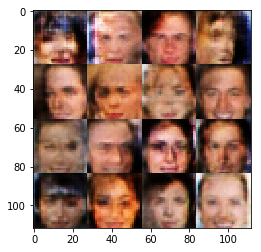

Epoch 1/1 disc_loss:  1.152 gen_loss:  0.804
Epoch 1/1 disc_loss:  1.175 gen_loss:  0.754
Epoch 1/1 disc_loss:  1.228 gen_loss:  0.759
Epoch 1/1 disc_loss:  1.177 gen_loss:  0.712
Epoch 1/1 disc_loss:  1.293 gen_loss:  0.711
Epoch 1/1 disc_loss:  1.179 gen_loss:  0.735
Epoch 1/1 disc_loss:  0.942 gen_loss:  1.152
Epoch 1/1 disc_loss:  1.268 gen_loss:  0.648
Epoch 1/1 disc_loss:  2.076 gen_loss:  0.204
Epoch 1/1 disc_loss:  1.209 gen_loss:  0.656


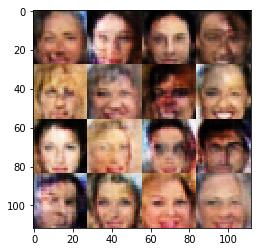

Epoch 1/1 disc_loss:  0.919 gen_loss:  1.788
Epoch 1/1 disc_loss:  1.354 gen_loss:  0.672
Epoch 1/1 disc_loss:  1.744 gen_loss:  0.403
Epoch 1/1 disc_loss:  1.112 gen_loss:  1.218
Epoch 1/1 disc_loss:  1.236 gen_loss:  0.600
Epoch 1/1 disc_loss:  0.940 gen_loss:  1.123
Epoch 1/1 disc_loss:  1.386 gen_loss:  0.491
Epoch 1/1 disc_loss:  1.050 gen_loss:  0.814
Epoch 1/1 disc_loss:  0.955 gen_loss:  1.063
Epoch 1/1 disc_loss:  1.042 gen_loss:  0.855


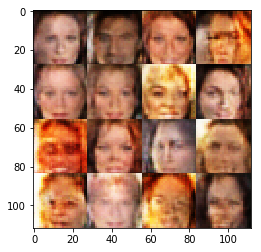

Epoch 1/1 disc_loss:  0.866 gen_loss:  1.107
Epoch 1/1 disc_loss:  1.359 gen_loss:  0.505
Epoch 1/1 disc_loss:  1.516 gen_loss:  0.523
Epoch 1/1 disc_loss:  1.133 gen_loss:  0.932
Epoch 1/1 disc_loss:  1.193 gen_loss:  0.673
Epoch 1/1 disc_loss:  1.247 gen_loss:  0.852
Epoch 1/1 disc_loss:  0.958 gen_loss:  0.982
Epoch 1/1 disc_loss:  2.147 gen_loss:  0.314
Epoch 1/1 disc_loss:  0.848 gen_loss:  1.358
Epoch 1/1 disc_loss:  1.758 gen_loss:  0.357


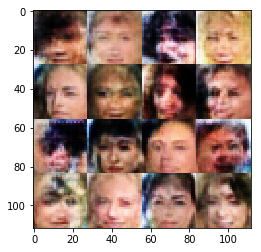

Epoch 1/1 disc_loss:  1.300 gen_loss:  0.649
Epoch 1/1 disc_loss:  1.397 gen_loss:  0.625
Epoch 1/1 disc_loss:  1.123 gen_loss:  1.099
Epoch 1/1 disc_loss:  0.911 gen_loss:  1.576
Epoch 1/1 disc_loss:  1.089 gen_loss:  0.952
Epoch 1/1 disc_loss:  1.392 gen_loss:  0.595
Epoch 1/1 disc_loss:  1.534 gen_loss:  0.411
Epoch 1/1 disc_loss:  0.963 gen_loss:  0.835
Epoch 1/1 disc_loss:  1.034 gen_loss:  0.919
Epoch 1/1 disc_loss:  1.198 gen_loss:  0.772


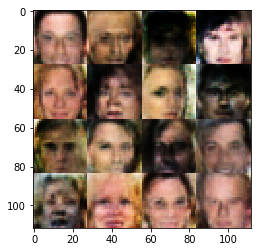

Epoch 1/1 disc_loss:  1.038 gen_loss:  1.217
Epoch 1/1 disc_loss:  1.209 gen_loss:  0.709
Epoch 1/1 disc_loss:  1.270 gen_loss:  0.706
Epoch 1/1 disc_loss:  1.134 gen_loss:  0.747
Epoch 1/1 disc_loss:  1.085 gen_loss:  0.959
Epoch 1/1 disc_loss:  1.064 gen_loss:  1.293
Epoch 1/1 disc_loss:  1.838 gen_loss:  0.264
Epoch 1/1 disc_loss:  1.454 gen_loss:  0.606
Epoch 1/1 disc_loss:  1.178 gen_loss:  0.822
Epoch 1/1 disc_loss:  1.230 gen_loss:  0.581


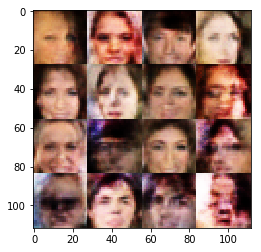

Epoch 1/1 disc_loss:  1.171 gen_loss:  0.926
Epoch 1/1 disc_loss:  1.302 gen_loss:  0.852
Epoch 1/1 disc_loss:  1.196 gen_loss:  0.935
Epoch 1/1 disc_loss:  1.078 gen_loss:  0.846
Epoch 1/1 disc_loss:  0.963 gen_loss:  1.203
Epoch 1/1 disc_loss:  1.045 gen_loss:  1.070
Epoch 1/1 disc_loss:  2.093 gen_loss:  0.264
Epoch 1/1 disc_loss:  1.115 gen_loss:  0.835
Epoch 1/1 disc_loss:  1.402 gen_loss:  0.653
Epoch 1/1 disc_loss:  1.708 gen_loss:  0.338


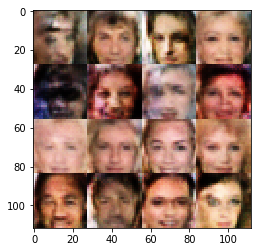

Epoch 1/1 disc_loss:  1.768 gen_loss:  0.475
Epoch 1/1 disc_loss:  1.038 gen_loss:  0.896
Epoch 1/1 disc_loss:  1.238 gen_loss:  0.644
Epoch 1/1 disc_loss:  1.838 gen_loss:  0.287
Epoch 1/1 disc_loss:  1.067 gen_loss:  0.974
Epoch 1/1 disc_loss:  1.125 gen_loss:  0.758
Epoch 1/1 disc_loss:  1.477 gen_loss:  0.567
Epoch 1/1 disc_loss:  1.139 gen_loss:  0.759
Epoch 1/1 disc_loss:  1.082 gen_loss:  0.968
Epoch 1/1 disc_loss:  1.060 gen_loss:  1.070


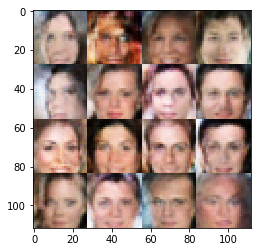

Epoch 1/1 disc_loss:  2.212 gen_loss:  0.204
Epoch 1/1 disc_loss:  1.671 gen_loss:  0.389
Epoch 1/1 disc_loss:  1.231 gen_loss:  0.665
Epoch 1/1 disc_loss:  2.295 gen_loss:  0.184
Epoch 1/1 disc_loss:  1.442 gen_loss:  0.519
Epoch 1/1 disc_loss:  1.672 gen_loss:  0.352
Epoch 1/1 disc_loss:  1.391 gen_loss:  0.593
Epoch 1/1 disc_loss:  1.233 gen_loss:  0.776
Epoch 1/1 disc_loss:  1.200 gen_loss:  0.911
Epoch 1/1 disc_loss:  1.669 gen_loss:  0.577


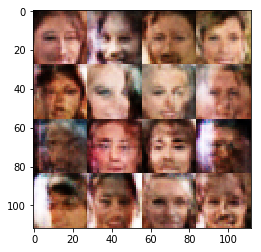

Epoch 1/1 disc_loss:  1.026 gen_loss:  0.930
Epoch 1/1 disc_loss:  1.478 gen_loss:  0.486
Epoch 1/1 disc_loss:  1.122 gen_loss:  1.057
Epoch 1/1 disc_loss:  1.163 gen_loss:  0.703
Epoch 1/1 disc_loss:  1.119 gen_loss:  1.330
Epoch 1/1 disc_loss:  1.112 gen_loss:  0.846
Epoch 1/1 disc_loss:  1.496 gen_loss:  0.758
Epoch 1/1 disc_loss:  2.029 gen_loss:  0.254
Epoch 1/1 disc_loss:  1.261 gen_loss:  0.688
Epoch 1/1 disc_loss:  0.971 gen_loss:  1.359


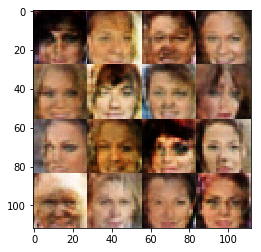

Epoch 1/1 disc_loss:  1.283 gen_loss:  0.655
Epoch 1/1 disc_loss:  1.629 gen_loss:  0.464
Epoch 1/1 disc_loss:  1.251 gen_loss:  0.633
Epoch 1/1 disc_loss:  1.267 gen_loss:  0.690
Epoch 1/1 disc_loss:  1.468 gen_loss:  0.445
Epoch 1/1 disc_loss:  1.249 gen_loss:  1.330
Epoch 1/1 disc_loss:  1.157 gen_loss:  0.752
Epoch 1/1 disc_loss:  1.311 gen_loss:  0.661
Epoch 1/1 disc_loss:  0.831 gen_loss:  1.443
Epoch 1/1 disc_loss:  1.135 gen_loss:  0.742


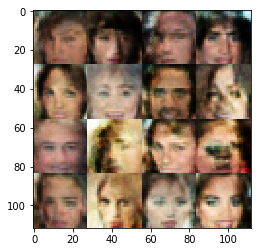

Epoch 1/1 disc_loss:  1.155 gen_loss:  1.012
Epoch 1/1 disc_loss:  1.455 gen_loss:  0.500
Epoch 1/1 disc_loss:  1.225 gen_loss:  0.666
Epoch 1/1 disc_loss:  0.985 gen_loss:  1.208
Epoch 1/1 disc_loss:  1.136 gen_loss:  1.094
Epoch 1/1 disc_loss:  1.528 gen_loss:  0.462
Epoch 1/1 disc_loss:  1.451 gen_loss:  0.524
Epoch 1/1 disc_loss:  1.634 gen_loss:  0.385
Epoch 1/1 disc_loss:  1.063 gen_loss:  1.063
Epoch 1/1 disc_loss:  1.295 gen_loss:  0.699


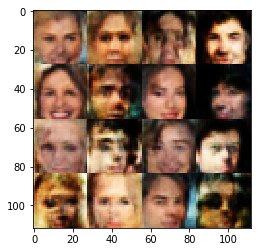

Epoch 1/1 disc_loss:  1.318 gen_loss:  0.653
Epoch 1/1 disc_loss:  1.078 gen_loss:  0.863
Epoch 1/1 disc_loss:  0.974 gen_loss:  0.944
Epoch 1/1 disc_loss:  1.080 gen_loss:  0.923
Epoch 1/1 disc_loss:  1.017 gen_loss:  1.092
Epoch 1/1 disc_loss:  1.411 gen_loss:  0.590
Epoch 1/1 disc_loss:  1.346 gen_loss:  0.771
Epoch 1/1 disc_loss:  1.188 gen_loss:  0.954
Epoch 1/1 disc_loss:  1.136 gen_loss:  0.843
Epoch 1/1 disc_loss:  1.449 gen_loss:  0.553


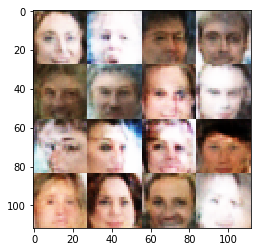

Epoch 1/1 disc_loss:  1.253 gen_loss:  0.764
Epoch 1/1 disc_loss:  1.192 gen_loss:  1.016
Epoch 1/1 disc_loss:  1.585 gen_loss:  0.394
Epoch 1/1 disc_loss:  1.373 gen_loss:  0.612
Epoch 1/1 disc_loss:  1.685 gen_loss:  0.390
Epoch 1/1 disc_loss:  1.136 gen_loss:  0.853
Epoch 1/1 disc_loss:  0.964 gen_loss:  1.262
Epoch 1/1 disc_loss:  1.172 gen_loss:  0.680
Epoch 1/1 disc_loss:  1.697 gen_loss:  0.329
Epoch 1/1 disc_loss:  1.295 gen_loss:  0.672


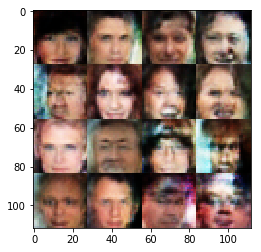

Epoch 1/1 disc_loss:  1.180 gen_loss:  0.895
Epoch 1/1 disc_loss:  1.082 gen_loss:  1.048
Epoch 1/1 disc_loss:  1.163 gen_loss:  0.819
Epoch 1/1 disc_loss:  1.450 gen_loss:  0.550
Epoch 1/1 disc_loss:  0.845 gen_loss:  1.382
Epoch 1/1 disc_loss:  1.104 gen_loss:  0.784
Epoch 1/1 disc_loss:  1.421 gen_loss:  0.619
Epoch 1/1 disc_loss:  0.838 gen_loss:  1.344
Epoch 1/1 disc_loss:  1.389 gen_loss:  0.505
Epoch 1/1 disc_loss:  1.227 gen_loss:  0.922


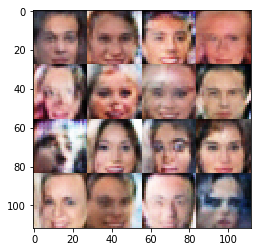

Epoch 1/1 disc_loss:  1.113 gen_loss:  1.006
Epoch 1/1 disc_loss:  1.574 gen_loss:  0.385
Epoch 1/1 disc_loss:  1.770 gen_loss:  0.375
Epoch 1/1 disc_loss:  1.519 gen_loss:  0.432
Epoch 1/1 disc_loss:  1.095 gen_loss:  0.844
Epoch 1/1 disc_loss:  1.578 gen_loss:  0.564
Epoch 1/1 disc_loss:  1.126 gen_loss:  0.925
Epoch 1/1 disc_loss:  1.435 gen_loss:  0.611
Epoch 1/1 disc_loss:  1.143 gen_loss:  0.883
Epoch 1/1 disc_loss:  1.015 gen_loss:  0.987


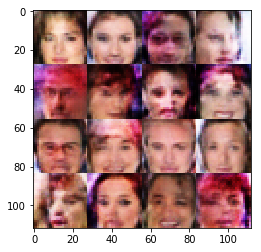

Epoch 1/1 disc_loss:  1.277 gen_loss:  0.924
Epoch 1/1 disc_loss:  1.055 gen_loss:  1.133
Epoch 1/1 disc_loss:  1.105 gen_loss:  0.847
Epoch 1/1 disc_loss:  1.141 gen_loss:  0.961
Epoch 1/1 disc_loss:  1.384 gen_loss:  0.608
Epoch 1/1 disc_loss:  1.333 gen_loss:  0.787
Epoch 1/1 disc_loss:  1.561 gen_loss:  0.382
Epoch 1/1 disc_loss:  1.379 gen_loss:  0.533
Epoch 1/1 disc_loss:  1.022 gen_loss:  1.067
Epoch 1/1 disc_loss:  1.308 gen_loss:  0.808


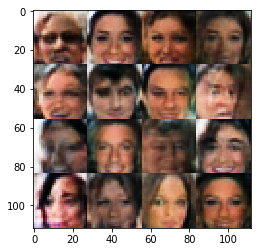

Epoch 1/1 disc_loss:  1.103 gen_loss:  1.192
Epoch 1/1 disc_loss:  1.410 gen_loss:  0.640
Epoch 1/1 disc_loss:  1.481 gen_loss:  0.483
Epoch 1/1 disc_loss:  1.233 gen_loss:  0.693
Epoch 1/1 disc_loss:  1.363 gen_loss:  0.639
Epoch 1/1 disc_loss:  1.544 gen_loss:  0.545
Epoch 1/1 disc_loss:  1.376 gen_loss:  0.499
Epoch 1/1 disc_loss:  1.689 gen_loss:  0.379
Epoch 1/1 disc_loss:  1.009 gen_loss:  0.946
Epoch 1/1 disc_loss:  2.061 gen_loss:  0.315


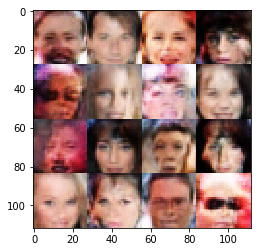

Epoch 1/1 disc_loss:  1.114 gen_loss:  1.146
Epoch 1/1 disc_loss:  0.918 gen_loss:  1.672
Epoch 1/1 disc_loss:  1.471 gen_loss:  0.546
Epoch 1/1 disc_loss:  1.550 gen_loss:  0.421
Epoch 1/1 disc_loss:  1.176 gen_loss:  0.745
Epoch 1/1 disc_loss:  0.871 gen_loss:  1.286
Epoch 1/1 disc_loss:  0.966 gen_loss:  0.945
Epoch 1/1 disc_loss:  1.500 gen_loss:  0.492
Epoch 1/1 disc_loss:  1.550 gen_loss:  0.741
Epoch 1/1 disc_loss:  1.088 gen_loss:  0.768


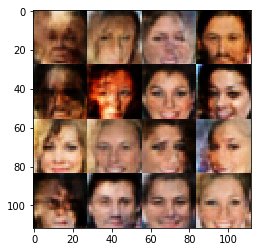

Epoch 1/1 disc_loss:  1.023 gen_loss:  0.938
Epoch 1/1 disc_loss:  1.088 gen_loss:  0.873
Epoch 1/1 disc_loss:  0.980 gen_loss:  1.117
Epoch 1/1 disc_loss:  1.964 gen_loss:  0.229
Epoch 1/1 disc_loss:  1.077 gen_loss:  0.881
Epoch 1/1 disc_loss:  1.779 gen_loss:  0.361
Epoch 1/1 disc_loss:  1.437 gen_loss:  0.610
Epoch 1/1 disc_loss:  1.198 gen_loss:  0.771
Epoch 1/1 disc_loss:  1.670 gen_loss:  0.438
Epoch 1/1 disc_loss:  1.490 gen_loss:  0.603


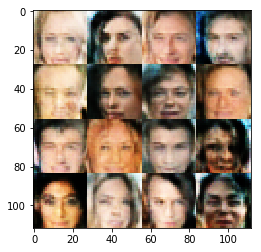

Epoch 1/1 disc_loss:  1.411 gen_loss:  0.547
Epoch 1/1 disc_loss:  1.344 gen_loss:  1.053
Epoch 1/1 disc_loss:  1.270 gen_loss:  0.767
Epoch 1/1 disc_loss:  1.054 gen_loss:  1.029
Epoch 1/1 disc_loss:  1.877 gen_loss:  0.305
Epoch 1/1 disc_loss:  1.145 gen_loss:  0.952
Epoch 1/1 disc_loss:  1.345 gen_loss:  0.586
Epoch 1/1 disc_loss:  1.133 gen_loss:  0.767
Epoch 1/1 disc_loss:  1.341 gen_loss:  0.723
Epoch 1/1 disc_loss:  1.179 gen_loss:  0.791


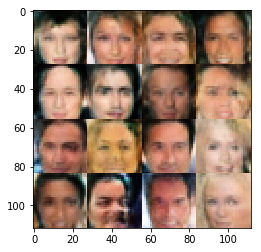

Epoch 1/1 disc_loss:  1.011 gen_loss:  1.102
Epoch 1/1 disc_loss:  1.270 gen_loss:  0.668
Epoch 1/1 disc_loss:  1.198 gen_loss:  1.270
Epoch 1/1 disc_loss:  1.517 gen_loss:  0.630
Epoch 1/1 disc_loss:  1.451 gen_loss:  0.512
Epoch 1/1 disc_loss:  1.190 gen_loss:  1.092
Epoch 1/1 disc_loss:  1.506 gen_loss:  0.539
Epoch 1/1 disc_loss:  0.895 gen_loss:  1.072
Epoch 1/1 disc_loss:  1.018 gen_loss:  1.439
Epoch 1/1 disc_loss:  1.649 gen_loss:  0.436


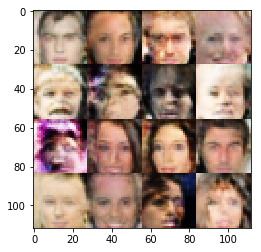

Epoch 1/1 disc_loss:  1.631 gen_loss:  0.456
Epoch 1/1 disc_loss:  1.393 gen_loss:  0.706
Epoch 1/1 disc_loss:  1.283 gen_loss:  0.656
Epoch 1/1 disc_loss:  1.628 gen_loss:  0.471
Epoch 1/1 disc_loss:  1.464 gen_loss:  0.467
Epoch 1/1 disc_loss:  1.278 gen_loss:  0.807
Epoch 1/1 disc_loss:  1.283 gen_loss:  0.827
Epoch 1/1 disc_loss:  1.299 gen_loss:  0.728
Epoch 1/1 disc_loss:  1.327 gen_loss:  0.551
Epoch 1/1 disc_loss:  0.896 gen_loss:  1.079


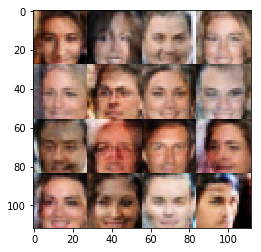

Epoch 1/1 disc_loss:  1.723 gen_loss:  0.345
Epoch 1/1 disc_loss:  1.217 gen_loss:  0.748
Epoch 1/1 disc_loss:  1.125 gen_loss:  0.934
Epoch 1/1 disc_loss:  1.137 gen_loss:  0.764
Epoch 1/1 disc_loss:  1.312 gen_loss:  0.642
Epoch 1/1 disc_loss:  1.275 gen_loss:  0.677
Epoch 1/1 disc_loss:  1.154 gen_loss:  0.906
Epoch 1/1 disc_loss:  1.042 gen_loss:  1.260
Epoch 1/1 disc_loss:  0.990 gen_loss:  1.227
Epoch 1/1 disc_loss:  1.804 gen_loss:  0.434


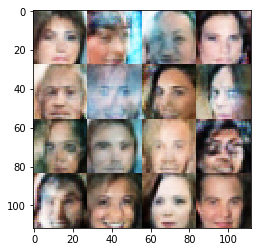

Epoch 1/1 disc_loss:  1.477 gen_loss:  0.557
Epoch 1/1 disc_loss:  1.069 gen_loss:  0.808
Epoch 1/1 disc_loss:  1.293 gen_loss:  0.667
Epoch 1/1 disc_loss:  1.231 gen_loss:  0.761
Epoch 1/1 disc_loss:  1.352 gen_loss:  0.786
Epoch 1/1 disc_loss:  1.905 gen_loss:  0.284
Epoch 1/1 disc_loss:  1.363 gen_loss:  0.600
Epoch 1/1 disc_loss:  0.974 gen_loss:  0.983
Epoch 1/1 disc_loss:  0.972 gen_loss:  1.422
Epoch 1/1 disc_loss:  2.498 gen_loss:  0.147


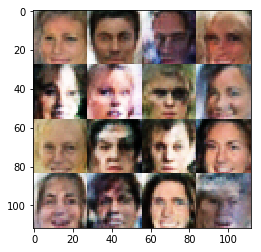

Epoch 1/1 disc_loss:  0.999 gen_loss:  0.954
Epoch 1/1 disc_loss:  1.024 gen_loss:  1.247
Epoch 1/1 disc_loss:  1.328 gen_loss:  0.614
Epoch 1/1 disc_loss:  1.208 gen_loss:  0.849
Epoch 1/1 disc_loss:  1.283 gen_loss:  0.630
Epoch 1/1 disc_loss:  1.406 gen_loss:  0.557
Epoch 1/1 disc_loss:  1.171 gen_loss:  0.904
Epoch 1/1 disc_loss:  1.352 gen_loss:  0.550
Epoch 1/1 disc_loss:  1.027 gen_loss:  0.963
Epoch 1/1 disc_loss:  1.097 gen_loss:  0.898


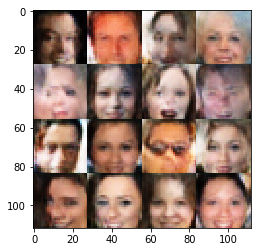

Epoch 1/1 disc_loss:  1.274 gen_loss:  0.750
Epoch 1/1 disc_loss:  1.546 gen_loss:  0.554
Epoch 1/1 disc_loss:  1.216 gen_loss:  0.726
Epoch 1/1 disc_loss:  1.114 gen_loss:  1.008
Epoch 1/1 disc_loss:  1.225 gen_loss:  0.933
Epoch 1/1 disc_loss:  1.282 gen_loss:  0.557
Epoch 1/1 disc_loss:  1.026 gen_loss:  1.079
Epoch 1/1 disc_loss:  1.106 gen_loss:  1.069
Epoch 1/1 disc_loss:  1.081 gen_loss:  0.894
Epoch 1/1 disc_loss:  1.654 gen_loss:  0.430


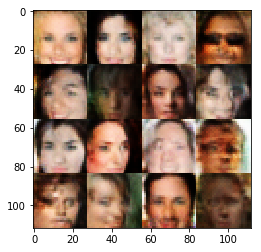

Epoch 1/1 disc_loss:  1.136 gen_loss:  0.710
Epoch 1/1 disc_loss:  1.012 gen_loss:  1.087
Epoch 1/1 disc_loss:  0.869 gen_loss:  1.204
Epoch 1/1 disc_loss:  1.095 gen_loss:  0.938
Epoch 1/1 disc_loss:  1.114 gen_loss:  0.789
Epoch 1/1 disc_loss:  1.802 gen_loss:  0.414
Epoch 1/1 disc_loss:  1.367 gen_loss:  0.629
Epoch 1/1 disc_loss:  1.166 gen_loss:  0.751
Epoch 1/1 disc_loss:  1.157 gen_loss:  1.109
Epoch 1/1 disc_loss:  1.236 gen_loss:  0.742


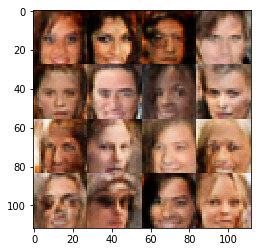

Epoch 1/1 disc_loss:  1.114 gen_loss:  1.101
Epoch 1/1 disc_loss:  1.173 gen_loss:  0.861
Epoch 1/1 disc_loss:  1.395 gen_loss:  0.776
Epoch 1/1 disc_loss:  1.157 gen_loss:  1.022
Epoch 1/1 disc_loss:  1.271 gen_loss:  0.686
Epoch 1/1 disc_loss:  1.569 gen_loss:  0.493
Epoch 1/1 disc_loss:  1.071 gen_loss:  0.855
Epoch 1/1 disc_loss:  1.026 gen_loss:  1.137
Epoch 1/1 disc_loss:  1.787 gen_loss:  0.440
Epoch 1/1 disc_loss:  1.301 gen_loss:  0.581


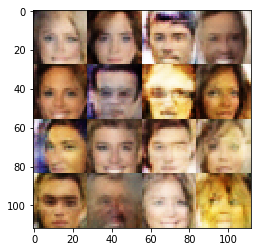

Epoch 1/1 disc_loss:  1.209 gen_loss:  1.040
Epoch 1/1 disc_loss:  1.070 gen_loss:  1.163
Epoch 1/1 disc_loss:  1.571 gen_loss:  0.434
Epoch 1/1 disc_loss:  0.976 gen_loss:  0.904
Epoch 1/1 disc_loss:  1.076 gen_loss:  0.869
Epoch 1/1 disc_loss:  1.111 gen_loss:  0.941
Epoch 1/1 disc_loss:  1.293 gen_loss:  0.696
Epoch 1/1 disc_loss:  1.216 gen_loss:  0.847
Epoch 1/1 disc_loss:  1.145 gen_loss:  0.778
Epoch 1/1 disc_loss:  1.504 gen_loss:  0.664


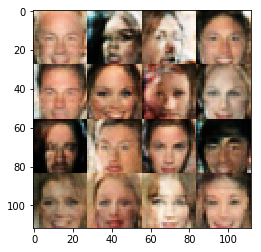

Epoch 1/1 disc_loss:  1.422 gen_loss:  0.734
Epoch 1/1 disc_loss:  1.346 gen_loss:  0.554
Epoch 1/1 disc_loss:  1.383 gen_loss:  0.673
Epoch 1/1 disc_loss:  1.393 gen_loss:  0.645
Epoch 1/1 disc_loss:  1.288 gen_loss:  0.662
Epoch 1/1 disc_loss:  1.545 gen_loss:  0.470
Epoch 1/1 disc_loss:  1.415 gen_loss:  0.493
Epoch 1/1 disc_loss:  1.240 gen_loss:  0.727
Epoch 1/1 disc_loss:  1.099 gen_loss:  1.485
Epoch 1/1 disc_loss:  1.268 gen_loss:  0.805


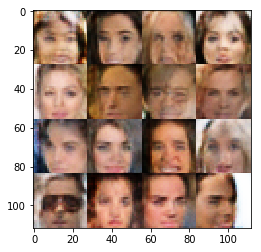

Epoch 1/1 disc_loss:  1.432 gen_loss:  1.175
Epoch 1/1 disc_loss:  1.490 gen_loss:  0.512
Epoch 1/1 disc_loss:  1.205 gen_loss:  0.670
Epoch 1/1 disc_loss:  1.086 gen_loss:  1.137
Epoch 1/1 disc_loss:  1.402 gen_loss:  0.496
Epoch 1/1 disc_loss:  1.217 gen_loss:  0.921
Epoch 1/1 disc_loss:  1.145 gen_loss:  0.908
Epoch 1/1 disc_loss:  1.674 gen_loss:  0.429
Epoch 1/1 disc_loss:  1.141 gen_loss:  0.950
Epoch 1/1 disc_loss:  1.570 gen_loss:  0.469


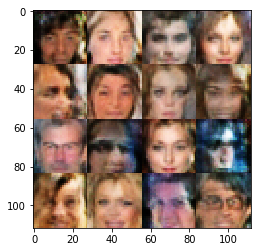

Epoch 1/1 disc_loss:  1.133 gen_loss:  0.765
Epoch 1/1 disc_loss:  0.937 gen_loss:  1.294
Epoch 1/1 disc_loss:  1.355 gen_loss:  0.590
Epoch 1/1 disc_loss:  1.220 gen_loss:  0.886
Epoch 1/1 disc_loss:  1.061 gen_loss:  0.954
Epoch 1/1 disc_loss:  0.871 gen_loss:  1.148
Epoch 1/1 disc_loss:  1.175 gen_loss:  0.790
Epoch 1/1 disc_loss:  1.485 gen_loss:  0.651
Epoch 1/1 disc_loss:  1.616 gen_loss:  0.540
Epoch 1/1 disc_loss:  1.572 gen_loss:  0.464


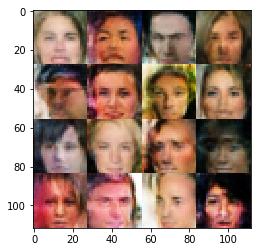

Epoch 1/1 disc_loss:  1.557 gen_loss:  0.498
Epoch 1/1 disc_loss:  1.765 gen_loss:  0.328
Epoch 1/1 disc_loss:  1.088 gen_loss:  1.171
Epoch 1/1 disc_loss:  1.202 gen_loss:  0.827
Epoch 1/1 disc_loss:  1.605 gen_loss:  0.442
Epoch 1/1 disc_loss:  1.356 gen_loss:  0.589
Epoch 1/1 disc_loss:  1.017 gen_loss:  1.025
Epoch 1/1 disc_loss:  1.276 gen_loss:  0.845
Epoch 1/1 disc_loss:  1.330 gen_loss:  0.645
Epoch 1/1 disc_loss:  1.228 gen_loss:  0.882


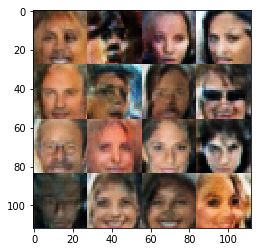

Epoch 1/1 disc_loss:  1.277 gen_loss:  0.852
Epoch 1/1 disc_loss:  1.134 gen_loss:  0.915
Epoch 1/1 disc_loss:  1.595 gen_loss:  0.375
Epoch 1/1 disc_loss:  1.358 gen_loss:  0.586
Epoch 1/1 disc_loss:  1.214 gen_loss:  0.822
Epoch 1/1 disc_loss:  1.231 gen_loss:  0.780
Epoch 1/1 disc_loss:  1.104 gen_loss:  0.842
Epoch 1/1 disc_loss:  0.947 gen_loss:  1.481
Epoch 1/1 disc_loss:  1.480 gen_loss:  0.566
Epoch 1/1 disc_loss:  1.345 gen_loss:  0.569


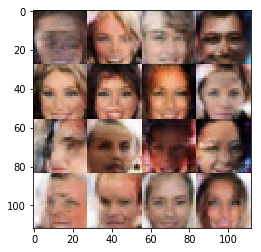

Epoch 1/1 disc_loss:  1.184 gen_loss:  0.840
Epoch 1/1 disc_loss:  1.612 gen_loss:  0.385
Epoch 1/1 disc_loss:  1.487 gen_loss:  0.612
Epoch 1/1 disc_loss:  1.194 gen_loss:  0.923
Epoch 1/1 disc_loss:  1.309 gen_loss:  0.625
Epoch 1/1 disc_loss:  1.318 gen_loss:  0.696
Epoch 1/1 disc_loss:  1.465 gen_loss:  0.534
Epoch 1/1 disc_loss:  1.200 gen_loss:  0.752
Epoch 1/1 disc_loss:  1.400 gen_loss:  0.576
Epoch 1/1 disc_loss:  1.357 gen_loss:  0.543


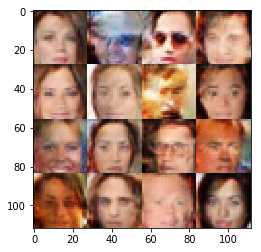

Epoch 1/1 disc_loss:  0.844 gen_loss:  1.159
Epoch 1/1 disc_loss:  1.539 gen_loss:  0.424
Epoch 1/1 disc_loss:  1.627 gen_loss:  0.401
Epoch 1/1 disc_loss:  1.226 gen_loss:  0.806
Epoch 1/1 disc_loss:  1.490 gen_loss:  0.532
Epoch 1/1 disc_loss:  1.382 gen_loss:  0.602
Epoch 1/1 disc_loss:  1.166 gen_loss:  0.768
Epoch 1/1 disc_loss:  1.374 gen_loss:  0.613
Epoch 1/1 disc_loss:  1.294 gen_loss:  0.618
Epoch 1/1 disc_loss:  1.471 gen_loss:  0.861


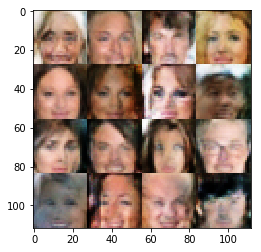

Epoch 1/1 disc_loss:  1.498 gen_loss:  0.637
Epoch 1/1 disc_loss:  1.451 gen_loss:  0.547
Epoch 1/1 disc_loss:  0.998 gen_loss:  1.206
Epoch 1/1 disc_loss:  1.072 gen_loss:  1.078
Epoch 1/1 disc_loss:  1.110 gen_loss:  1.231
Epoch 1/1 disc_loss:  1.220 gen_loss:  0.809
Epoch 1/1 disc_loss:  1.744 gen_loss:  0.385
Epoch 1/1 disc_loss:  1.431 gen_loss:  0.529
Epoch 1/1 disc_loss:  1.332 gen_loss:  0.703
Epoch 1/1 disc_loss:  1.177 gen_loss:  0.781


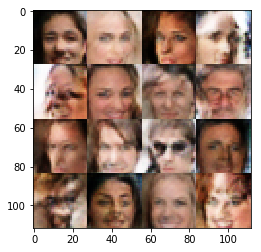

Epoch 1/1 disc_loss:  1.609 gen_loss:  0.395
Epoch 1/1 disc_loss:  1.256 gen_loss:  0.678
Epoch 1/1 disc_loss:  1.193 gen_loss:  0.798
Epoch 1/1 disc_loss:  1.114 gen_loss:  0.873
Epoch 1/1 disc_loss:  1.932 gen_loss:  0.313
Epoch 1/1 disc_loss:  1.628 gen_loss:  0.414
Epoch 1/1 disc_loss:  1.297 gen_loss:  0.760
Epoch 1/1 disc_loss:  1.197 gen_loss:  0.759
Epoch 1/1 disc_loss:  1.195 gen_loss:  0.977
Epoch 1/1 disc_loss:  1.539 gen_loss:  0.575


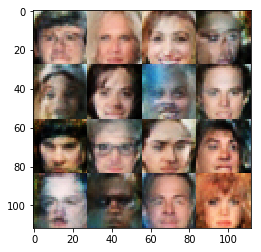

Epoch 1/1 disc_loss:  1.166 gen_loss:  0.861
Epoch 1/1 disc_loss:  0.999 gen_loss:  1.357
Epoch 1/1 disc_loss:  1.060 gen_loss:  0.893
Epoch 1/1 disc_loss:  0.936 gen_loss:  0.963
Epoch 1/1 disc_loss:  1.215 gen_loss:  0.678
Epoch 1/1 disc_loss:  1.333 gen_loss:  0.669
Epoch 1/1 disc_loss:  1.283 gen_loss:  0.924
Epoch 1/1 disc_loss:  1.611 gen_loss:  0.699
Epoch 1/1 disc_loss:  1.056 gen_loss:  0.990
Epoch 1/1 disc_loss:  2.157 gen_loss:  0.211


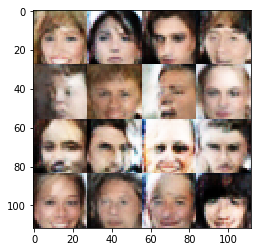

Epoch 1/1 disc_loss:  1.400 gen_loss:  0.563
Epoch 1/1 disc_loss:  1.436 gen_loss:  0.520
Epoch 1/1 disc_loss:  1.278 gen_loss:  0.801
Epoch 1/1 disc_loss:  1.313 gen_loss:  0.579
Epoch 1/1 disc_loss:  1.314 gen_loss:  1.071
Epoch 1/1 disc_loss:  1.135 gen_loss:  1.050
Epoch 1/1 disc_loss:  1.371 gen_loss:  0.840
Epoch 1/1 disc_loss:  1.161 gen_loss:  0.965
Epoch 1/1 disc_loss:  1.101 gen_loss:  0.887
Epoch 1/1 disc_loss:  1.511 gen_loss:  0.481


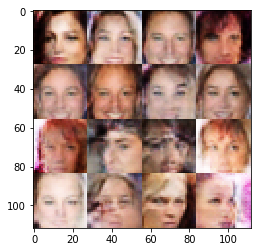

Epoch 1/1 disc_loss:  1.153 gen_loss:  0.899
Epoch 1/1 disc_loss:  1.461 gen_loss:  0.525
Epoch 1/1 disc_loss:  1.831 gen_loss:  0.670
Epoch 1/1 disc_loss:  1.013 gen_loss:  1.234
Epoch 1/1 disc_loss:  1.212 gen_loss:  0.760
Epoch 1/1 disc_loss:  1.152 gen_loss:  0.767
Epoch 1/1 disc_loss:  1.201 gen_loss:  0.819
Epoch 1/1 disc_loss:  1.996 gen_loss:  0.252
Epoch 1/1 disc_loss:  1.236 gen_loss:  0.815
Epoch 1/1 disc_loss:  1.306 gen_loss:  0.902


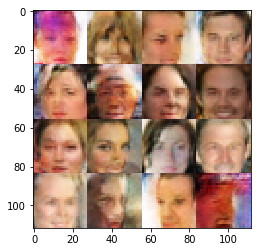

Epoch 1/1 disc_loss:  1.352 gen_loss:  0.763
Epoch 1/1 disc_loss:  1.217 gen_loss:  0.782
Epoch 1/1 disc_loss:  1.331 gen_loss:  0.519
Epoch 1/1 disc_loss:  1.239 gen_loss:  0.813
Epoch 1/1 disc_loss:  1.656 gen_loss:  0.436
Epoch 1/1 disc_loss:  1.404 gen_loss:  0.628
Epoch 1/1 disc_loss:  1.342 gen_loss:  0.794
Epoch 1/1 disc_loss:  1.402 gen_loss:  0.662
Epoch 1/1 disc_loss:  1.214 gen_loss:  0.797
Epoch 1/1 disc_loss:  1.372 gen_loss:  0.646


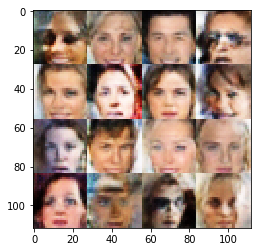

Epoch 1/1 disc_loss:  1.246 gen_loss:  0.957
Epoch 1/1 disc_loss:  1.014 gen_loss:  1.039
Epoch 1/1 disc_loss:  1.052 gen_loss:  0.925
Epoch 1/1 disc_loss:  1.063 gen_loss:  1.008
Epoch 1/1 disc_loss:  1.422 gen_loss:  0.618
Epoch 1/1 disc_loss:  1.297 gen_loss:  0.696
Epoch 1/1 disc_loss:  1.663 gen_loss:  0.524
Epoch 1/1 disc_loss:  1.299 gen_loss:  0.605
Epoch 1/1 disc_loss:  1.554 gen_loss:  0.447
Epoch 1/1 disc_loss:  1.387 gen_loss:  0.585


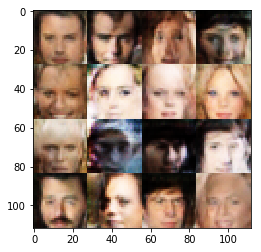

Epoch 1/1 disc_loss:  0.917 gen_loss:  1.138
Epoch 1/1 disc_loss:  1.984 gen_loss:  0.373
Epoch 1/1 disc_loss:  1.775 gen_loss:  0.518
Epoch 1/1 disc_loss:  1.260 gen_loss:  0.891
Epoch 1/1 disc_loss:  1.291 gen_loss:  1.160
Epoch 1/1 disc_loss:  1.413 gen_loss:  0.756
Epoch 1/1 disc_loss:  1.293 gen_loss:  0.693
Epoch 1/1 disc_loss:  1.403 gen_loss:  0.599
Epoch 1/1 disc_loss:  1.316 gen_loss:  0.627
Epoch 1/1 disc_loss:  1.095 gen_loss:  0.865


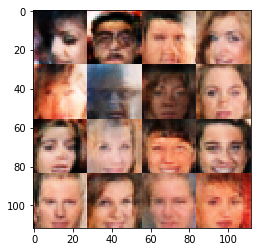

Epoch 1/1 disc_loss:  1.310 gen_loss:  0.603
Epoch 1/1 disc_loss:  1.018 gen_loss:  1.117
Epoch 1/1 disc_loss:  1.363 gen_loss:  0.646


In [97]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    celeb_hist, celeb_mod_path = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [102]:
np.save("./mnist_loss_history", hist)
np.save("./celeba_history", celeb_hist)

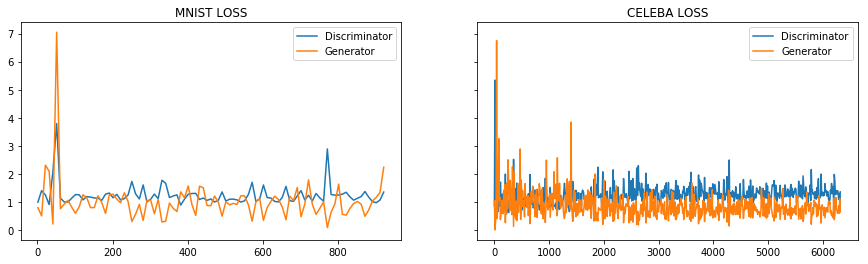

In [168]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

mnist_hist = np.load("./mnist_loss_history.npy")
fig.set_figwidth(15)
x1 = [i for i in range(1, len(mnist_hist)*10, 10)]
mnist_disc = mnist_hist[:, 0]
mnist_gen = mnist_hist[:, 1]
ax1.plot(x1, mnist_disc)
ax1.plot(x1, mnist_gen)
ax1.set_title("MNIST LOSS")
ax1.legend(["Discriminator", "Generator"])

celeb_hist = np.load("./celeba_history.npy")
x2 = [i for i in range(1, len(celeb_hist)*10, 10)]
celeb_disc = celeb_hist[:, 0]
celeb_gen = celeb_hist[:, 1]
ax2.plot(x2, celeb_disc)
ax2.plot(x2, celeb_gen)
ax2.set_title("CELEBA LOSS")
ax2.legend(["Discriminator", "Generator"])


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.